# Causal effect estimation in panel data

## Outline

- [Setup](#setup)
- [Overview: Robust Causal Inference with Panel Data](#overview:-robust-causal-inference-with-panel-data)
- [Example: California Smoking Cessation](#example:-california-smoking-cessation)
- [Causal Query: Counterfactual Prediction](#causal-query:-counterfactual-prediction)
- [Effect estimation with ordinary Bayesian inference](#effect-estimation-with-ordinary-bayesian-inference)
- [Robust effect estimation with modular Bayesian inference](#robust-effect-estimation-with-modular-bayesian-inference)
- [References](#references)

## Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.observational.handlers.cut import SingleStageCut
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

## Overview: Robust Causal Inference with Panel Data

In this notebook, we implement the synthetic difference-in-differences (SDID) estimator proposed in [1]. The SDID estimator combines the strengths of difference-in-differences and synthetic control methods through a two-stage weighted regression. 


## Example: California Smoking Cessation
As in [1], we analyze the California Smoking Cessation dataset [2] to estimate the effect cigarette taxes had in California. Specifically, in 1989, California passed Proposition 99 which increased cigarette taxes. We will estimate the impact this policy had on cigarette consumption using the California smoking cessation program dataset. This dataset consists of cigarette consumption of 39 states between 1970 to 2000, 38 of which are control units.

We start by loading and visualizing the dataset.

In [2]:
# Let's load the data from the author's github
DATA_URL = "https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv"
data = pd.read_csv(DATA_URL, sep=";")

# Model below assumes the response is coded as "y"
data["y"] = data["PacksPerCapita"].values.copy()

# Assign each unit to treatment or control group
data["in_treatment_group"] = 0
treated_units = data[data["treated"] == 1]["State"].unique()
data.loc[data["State"].isin(treated_units), "in_treatment_group"] = 1

# Must be that in unit_index, the first 1, ... N_co indcs correspond to control units and
# the remaining N_co + 1, ..., N correspond to treated units. To ensure this, we sort the 
# dataframe by `Year` and `in_treatment_group`
data = data.sort_values(["Year", "in_treatment_group"]) 

# Assign unique integer ids for each state and each time
data["unit_index"] = pd.factorize(data["State"].values)[0]
data["time_index"] = pd.factorize(data["Year"].values)[0]

In [3]:
# Show first few rows of the dataset
data.head()

,State,Year,PacksPerCapita,treated,y,in_treatment_group,unit_index,time_index
0,Alabama,1970,89.800003,0,89.800003,0,0,0
1,Arkansas,1970,100.300003,0,100.300003,0,1,0
2,Colorado,1970,124.800003,0,124.800003,0,2,0
3,Connecticut,1970,120.000000,0,120.000000,0,3,0
4,Delaware,1970,155.000000,0,155.000000,0,4,0


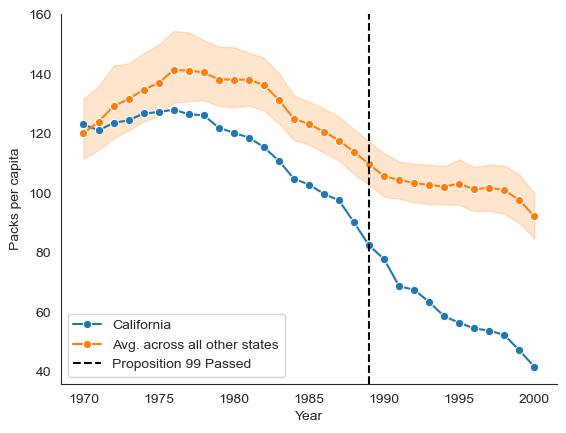

In [4]:
sns.lineplot(
    x=data[data["State"] == "California"]["Year"],
    y=data[data["State"] == "California"]["PacksPerCapita"],
    marker="o",
    label='California',
)

# The shaded area is the plot is the 95% confidence interval around the mean
sns.lineplot(
    x=data[data["State"] != "California"]["Year"],
    y=data[data["State"] != "California"]["PacksPerCapita"],
    marker="o",
    label='Avg. across all other states',
)

plt.axvline(
    1989, label="Proposition 99 Passed", color="black", linestyle="dashed"
)
plt.ylabel("Packs per capita")
sns.despine()
plt.legend()

## Causal Query: Counterfactual Prediction

In this setting we would like to estimate a counterfactual: had California not raised cigarette taxes, what would have cigarette consumption been?

To estimate this effect, we implement a Bayesian analogue of the Synthetic Difference-in-Differences (SDID) estimator proposed in [1]. 

In [5]:
class BayesSDID(pyro.nn.PyroModule):
    def __init__(self, X: pd.DataFrame):
        """
        Input:
            X: dataframe with columns "unit_index", "time_index", "in_treatment_group", "y", "treated"
        
        Notes:
            Must be that in unit_index, the first 1, ... N_co indcs correspond to control units and
            the remaining N_co + 1, ..., N correspond to treated units
        """
        # Check that treated unit index are always larger than control unit index
        assert X[X["in_treatment_group"] == 0]["unit_index"].max() < X[X["in_treatment_group"] == 1]["unit_index"].min(), "All treated unit indices must be larger than control unit indices"
        super().__init__()
        self.X = X.copy()
        self.X = self.X.sort_values(["time_index", "time_index"])
        units_by_group = self.X[["unit_index", "in_treatment_group"]].drop_duplicates()
        self.N = units_by_group.shape[0] # number of units
        self.N_tr = units_by_group["in_treatment_group"].sum()  # number of treated units
        self.N_co = self.N - self.N_tr  # number of control units
        self.T_pre = self.X[self.X["treated"] == 1]["time_index"].min()  # number of pre-treatment periods
        self.T_post = self.X["time_index"].max() - self.T_pre + 1  # number of post-treatment periods
        self.T = self.T_pre + self.T_post  # total number of periods
        self.times_by_units = torch.tensor(pd.pivot_table(self.X, values="y", index="time_index", columns="unit_index").values).float()
        self.avg_y_post_treat = self.times_by_units[self.T_pre:, :self.N_co].mean(axis=0)  # average of each control unit over the post-treatment period
        self.y_pre_treat_tr_avg = self.times_by_units[:self.T_pre, self.N_co:].mean(axis=1)
        self.y = torch.tensor(self.X["y"].values)
        self.treated = torch.tensor(self.X["treated"].values)
        self.unit_index = list(self.X["unit_index"].values)
        self.time_index = list(self.X["time_index"].values)
    
    def _get_module_param(self, param, module_ix):
        if len(param.shape) > 1:
            return param[module_ix].squeeze()
        return param

    def sample_synthetic_control_weights(self):
        w0 = pyro.sample("w0", dist.Normal(0, 1)) # intercept
        w_co = pyro.sample("w_co", dist.Dirichlet(torch.ones(self.N_co))) # convex combination of control units
        return w0, w_co
    
    def sample_time_weights(self):
        lam_0 = pyro.sample("lam_0", dist.Normal(0, 10)) # intercept
        lam_pre = pyro.sample("lam_pre", dist.Dirichlet(torch.ones(self.T_pre))) # convex combination of time periods
        return lam_0, lam_pre

    def sample_response_params(self, prior_scale=10):
        # Intercept, time fixed effects, treatment effect, unit fixed effects 
        mu = pyro.sample("mu", dist.Normal(0, prior_scale))
        beta = pyro.sample("beta", dist.Normal(0, prior_scale).expand((self.T,)).to_event(1))
        tau = pyro.sample("tau", dist.Normal(0, prior_scale))
        alpha = pyro.sample( "alpha", dist.Normal(0, prior_scale).expand((self.N,)).to_event(1))
        return mu, beta, tau, alpha
    
    def synthetic_control_unit(self, times_by_units: torch.Tensor, w0: torch.Tensor, w_co: torch.Tensor):
        return w0 + times_by_units.mv(w_co)
            
    def time_control(self, units_by_time: torch.Tensor, lam_0, lam_pre):
        return lam_0 + units_by_time.mv(lam_pre)

    def forward(self, **kwargs):        
        # Sample synthetic control weights, time weights, response parameters
        w0, w_co = self.sample_synthetic_control_weights()
        _shape_w_tr = list(w_co.shape)
        _shape_w_tr[-1] = self.N_tr
        w_co_tr = torch.cat([w_co, 1 / self.N_tr * torch.ones(_shape_w_tr)], axis=-1) # TODO: this assumes
        lam_0, lam_pre = self.sample_time_weights()
        _shape_lam_post = list(w_co.shape)
        _shape_lam_post[-1] = self.T_post
        lam_pre_post = torch.cat([lam_pre, 1 / self.T_post * torch.ones(_shape_lam_post)], axis=-1) # TODO: this assumes
        mu, beta, tau, alpha = self.sample_response_params()
                
        y_sc = self.synthetic_control_unit(
            self.times_by_units[:self.T_pre, :self.N_co], 
            self._get_module_param(w0, 0),
            self._get_module_param(w_co, 0)
        )
        
        with pyro.plate("synthetic_control_weights", self.T_pre):
            pyro.sample("y_pre_treat_tr_avg", dist.Normal(y_sc, 1.0), obs=self.y_pre_treat_tr_avg)

        # Time weights likelihood
        y_time = self.time_control(
            self.times_by_units[:self.T_pre, :].T, 
            self._get_module_param(lam_0, 0),
            self._get_module_param(lam_pre, 0)
        )

        with pyro.plate("time_weights", self.N_co):
            pyro.sample("avg_y_post_treat", dist.Normal(y_time[:self.N_co], 1.0), obs=self.avg_y_post_treat)

        # Response likelihood
        # Here we use the copy of module one parameters to response likelihood to change module one 
        # gradients
        weights = self._get_module_param(w_co_tr, 1)[self.unit_index] * self._get_module_param(lam_pre_post, 1)[self.time_index]
        f = self._get_module_param(mu, 1) + self._get_module_param(beta, 1)[self.time_index] + self._get_module_param(alpha, 1)[self.unit_index] + self._get_module_param(tau, 1) * self.treated
        with pyro.plate("response", self.N * self.T):
            pyro.sample("y", dist.Normal(f, 1 / weights), obs=self.y)


Let's visualize our Bayesian SDID probabilistic model.

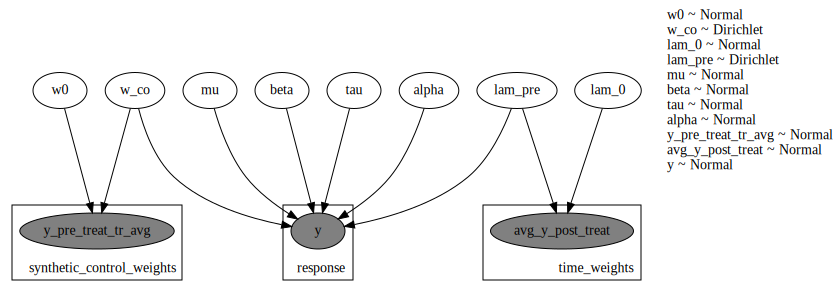

In [6]:
pyro.render_model(BayesSDID(data), render_params=True, render_distributions=True)

## Effect estimation with ordinary Bayesian inference

First, we estimate $\tau$ (the effect of Proposition 99) by performing joint Bayesian inference over all latents parameters in the model. We report the marginal approximate posterior over $\tau$.

In [7]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, n_steps=100, verbose=True, lr=.03, vi_family=AutoNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 1000 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [8]:
joint_guide = run_svi_inference(BayesSDID(data), vi_family=AutoNormal, n_steps=5000)

# Get posterior samples from the joint guide
joint_samples = Predictive(BayesSDID(data), guide=joint_guide, num_samples=1000)()

[iteration 0001] loss: 32569.7164
[iteration 1000] loss: 12121.5311
[iteration 2000] loss: 11939.9284
[iteration 3000] loss: 11955.8923
[iteration 4000] loss: 11944.6623
[iteration 5000] loss: 11932.9826


In [9]:
# Plotting utilities
def plot_tau(samples, ax):
    sns.kdeplot(samples["tau"], legend=None, ax=ax)
    sns.despine()
    ax.set_yticks([])
    ax.set_ylabel("Posterior density")
    ax.set_xlabel("$\\tau$")

def plot_synthetic_control(model, samples, data, ax):
    time_by_units = model.times_by_units[:, :model.N_co]
    w0_samples = samples["w0"].flatten()
    w_co_samples = samples["w_co"]
    n_samples = w0_samples.shape[0]
    y_sc_samples = [model.synthetic_control_unit(time_by_units, w0_samples[i], w_co_samples[i].flatten()) for i in range(n_samples)]
    y_sc_samples = torch.stack(y_sc_samples)

    # Plot the synthetic control unit with 90% CI and the actual treated unit (California)
    sns.lineplot(x=sorted(data['Year'].unique()), y=y_sc_samples.mean(axis=0), label="Synthetic control unit (90% CI)", ax=ax)
    ax.fill_between(
        sorted(data['Year'].unique()),
        torch.quantile(y_sc_samples, .05, axis=0),
        torch.quantile(y_sc_samples, .95, axis=0),
        alpha=0.3,
    )
    sns.lineplot(
        x=data[data["State"] == "California"]["Year"],
        y=data[data["State"] == "California"]["PacksPerCapita"],
        marker="o",
        label='California',
        ax=ax,
    )

    ax.axvline(
        1989, label="Proposition 99 Passed", color="black", linestyle="dashed"
    )
    ax.set_ylabel("Packs per capita")
    sns.despine()
    plt.legend()

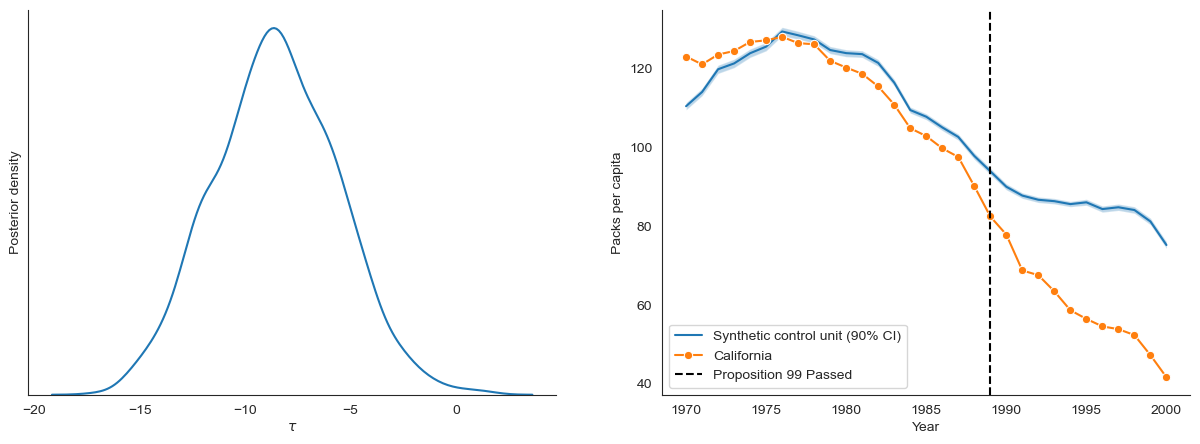

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_tau(joint_samples, ax=ax[0])
plot_synthetic_control(BayesSDID(data), joint_samples, data, ax=ax[1])

In [11]:
# Posterior summary of of tau
pd.Series(joint_samples['tau'].flatten()).describe().round(2)

count    1000.00
mean       -8.52
std         2.92
min       -16.95
25%       -10.50
50%        -8.57
75%        -6.51
max         1.41
dtype: float64

## Robust effect estimation with modular Bayesian inference

From the figure above, we see that the estimated synthetic control has non-trivial deviations from California during the pre-treatment period. To robustify our causal effect estimates, we use modular Bayesian inference and compute the "cut posterior" for $\tau$ [3]. Specifically, we define "module one" as all observed and latent variables associated with the time and synthetic control weights. We define "module two" as the latent variables used to compute the response likelihood. 

To approximate the cut posterior we use the variational inference objective discussed in [5].

In [12]:
def make_cut_model_single(data, module_one_vars):
    model = BayesSDID(data)
    def cut_model_single(*args, **kwargs):
        with IndexPlatesMessenger(), SingleStageCut(module_one_vars):
            model(*args, **kwargs)
    return cut_model_single

module_one_vars = ["w0", "w_co", "y_pre_treat_tr_avg", "lam_0", "lam_pre", "avg_y_post_treat"]
cut_model_single = make_cut_model_single(data, module_one_vars)
cut_guide_single = run_svi_inference(cut_model_single, vi_family=AutoNormal, n_steps=5000)
cut_samples_single = Predictive(cut_model_single, guide=cut_guide_single, num_samples=1000)()

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'__index_plate_____cut_plate'}
  warnings.warn(


[iteration 0001] loss: 33682.1019
[iteration 1000] loss: 14567.3586
[iteration 2000] loss: 14337.6747
[iteration 3000] loss: 14827.3438
[iteration 4000] loss: 14881.2637
[iteration 5000] loss: 14966.1440


Below we see that the synthetic control unit estimated from the cut posterior is a better fit to the treated unit (California) during the pre-treatment period 

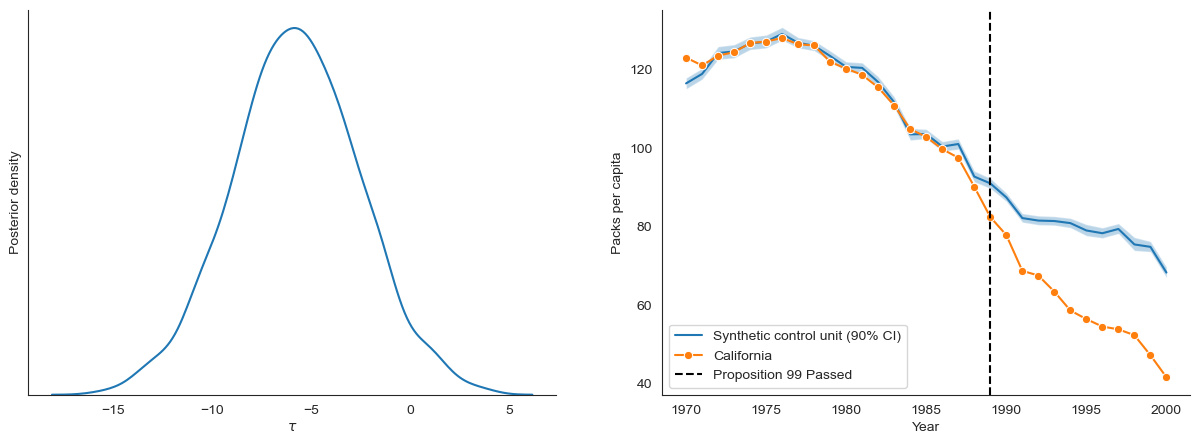

In [13]:
# Flatten to make use plotting utilities
cut_samples_reshaped = {
    "tau": cut_samples_single["tau"][:, 1, ...].squeeze(), 
    "w0": cut_samples_single["w0"][:, 0, ...],
    "w_co": cut_samples_single["w_co"][:, 0, ...]
}

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_tau(cut_samples_reshaped, ax=ax[0])
plot_synthetic_control(BayesSDID(data), cut_samples_reshaped, data, ax=ax[1])

In [14]:
# Posterior summary of of tau
pd.Series(cut_samples_reshaped['tau'].flatten()).describe().round(2)

count    1000.00
mean       -5.75
std         3.20
min       -15.69
25%        -7.86
50%        -5.77
75%        -3.59
max         3.77
dtype: float64

## References
1. https://www.aeaweb.org/articles?id=10.1257/aer.20190159
2. https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746
3. https://projecteuclid.org/journals/bayesian-analysis/volume-4/issue-1/Modularization-in-Bayesian-analysis-with-emphasis-on-analysis-of-computer/10.1214/09-BA404.full
4. https://arxiv.org/abs/2108.11066
5. https://arxiv.org/abs/2003.06804